In [1]:
import numpy as np
import skypy
from skypy.pipeline import Pipeline
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
from astropy.table import Table, Column
from descolors import BAND_COLORS

import os
import astropy.io.fits as pyfits
from scipy import interpolate
from astropy.cosmology import FlatLambdaCDM

from chainconsumer import ChainConsumer

%matplotlib inline

#plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':64})
## for Palatino and other serif fonts use:
plt.rc('font',**{'family':'serif','size':14})
plt.rc('text', usetex=True)

print(skypy.__version__)

0.6.dev17+gb2840ce


In [2]:
# simulated catalogue
sim = pyfits.open("lf_whole_z_range_remain.fits")[1].data
sim_p = pyfits.open("lf_whole_z_range_remain_p.fits")[1].data
sim_sf = pyfits.open("lf_whole_z_range_remain_sf.fits")[1].data

In [3]:
[print(name) for name in sim.dtype.names]

z
M_r
coeff
sm
sm_remain
m_des_true
m_hsc_true
m_vista_true
m_des_sim
des_sigma
m_hsc_sim
hsc_sigma
m_vista_sim
vista_sigma


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

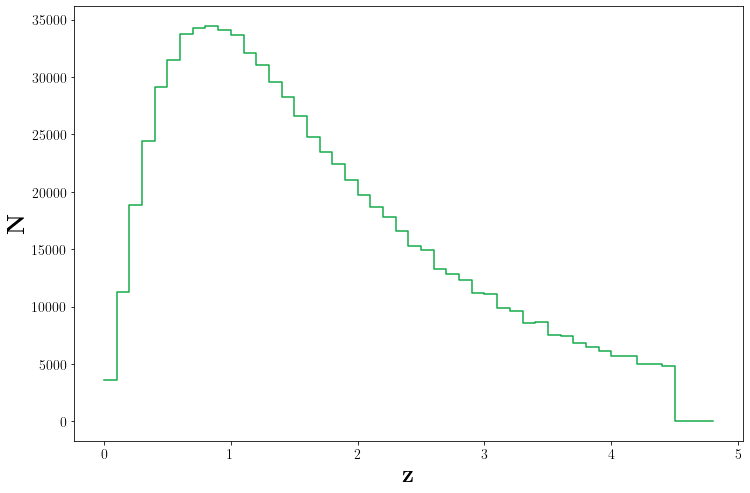

In [4]:
h_sim = np.histogram(sim['z'], bins=np.arange(0,5,0.1), density=False)[0]#/1.27/0.2


fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_xlabel(r'\textbf{z}', fontsize=24)
ax.set_ylabel(r'\textbf{N}', fontsize=24)
#ax.set_yscale('log')

ax.step(np.arange(0,5,0.1)[:-1], h_sim, where='post', c='#11aa46', label=r'\textbf{Simulation}')

plt.show()

In [5]:
sim['m_hsc_sim'].shape

(789272, 5)

In [6]:
sim = sim[sim['m_vista_sim'][:,3]<24.5]
sim_p = sim_p[sim_p['m_vista_sim'][:,3]<24.5]
sim_sf = sim_sf[sim_sf['m_vista_sim'][:,3]<24.5]

In [7]:
# DES Deep Fields
# des = pyfits.open("Y3_deep_fields_DB_wKNN_cat.fits")[1].data[::50]
# mask = np.where((des['bdf_mag_dered_calib_Ks']<24.5) & 
#                 #(des['bdf_mag_dered_calib_g']<30.) & 
#                 #(des['bdf_mag_dered_calib_r']<30.) &
#                 #(des['ra']>140) &
#                 (des['bdf_T']>0.01) &
#                 (des['flags']==0) &
#                 (des['mask_flags']==0) &
#                 (des['flags_nir']==0) &
#                 (des['mask_flags_nir']==0))[0]
# des = des[mask]
# print(len(des))

In [8]:
# COSMOS2020
cos = pyfits.open("COSMOS2020_Classic_kcorr_mass_uvj.fits")[1].data
print(len(cos))
mask = np.where((cos['photoz']>0) &
                (cos['photoz']<8.) &
                (cos['mag_Ks']<24.5) &
                (cos['lp_type']==0))[0]
                #(cos['UVJ_type']==False))[0]
cos = cos[mask]
print(len(cos))
# config['cuts'].update({'col':['photoz', 'photoz', 'mag_Ks', 'mag_Ks', 'lp_type', 'UVJ_type'], 
#                        'oper': ['grt', 'le', 'grt', 'le', 'is', 'is'], 
#                         'val': [0, 8., 16., 25., 0, False]})

422127
260920


In [9]:
cos_check = pyfits.open("COSMOS2020_Classic_processed.fits")[1].data
print(len(cos_check))
mask = np.where((cos_check['photoz']>0) &
                (cos_check['photoz']<8.) &
                (23.9-2.5*np.log10(cos_check['UVISTA_Ks_FLUX'])<24.5) &
                (cos_check['lp_type']==0))[0]
                #(cos['UVJ_type']==False))[0]
cos_check = cos_check[mask]
print(len(cos_check))


723897


/tmp/ipykernel_5242/3385037244.py:5: RuntimeWarning: invalid value encountered in log10
  (23.9-2.5*np.log10(cos_check['UVISTA_Ks_FLUX'])<24.5) &


260920


In [10]:
# order is different!!
print(cos_check['UVISTA_Ks_FLUX'][45823], cos['UVISTA_Ks_FLUX'][45823])

3.7600462436676025 1.271172285079956


In [11]:
coeffs_file = pyfits.open("cosmos2020_kcorr_coeffs.fits")[1].data
print(len(coeffs_file))
coeffs_file = coeffs_file[mask]
coeffs = coeffs_file['coeffs']
print(len(coeffs_file))

723897
260920


In [12]:
order = np.argsort(coeffs_file['ID'])
coeffs = coeffs[order,:]

In [13]:
order = np.argsort(cos['ID'])
cos = cos[order]

In [14]:
order = np.argsort(cos_check['ID'])
cos_check = cos_check[order]

In [15]:
print(cos_check['UVISTA_Ks_FLUX'][45823], cos['UVISTA_Ks_FLUX'][45823])

3.7600462436676025 3.7600462436676025


In [16]:
#coeffs_p = pyfits.open("cosmos2020_kcorr_coeffs.fits")[1].data
#coeffs_sf = pyfits.open("cosmos2020_kcorr_coeffs.fits")[1].data

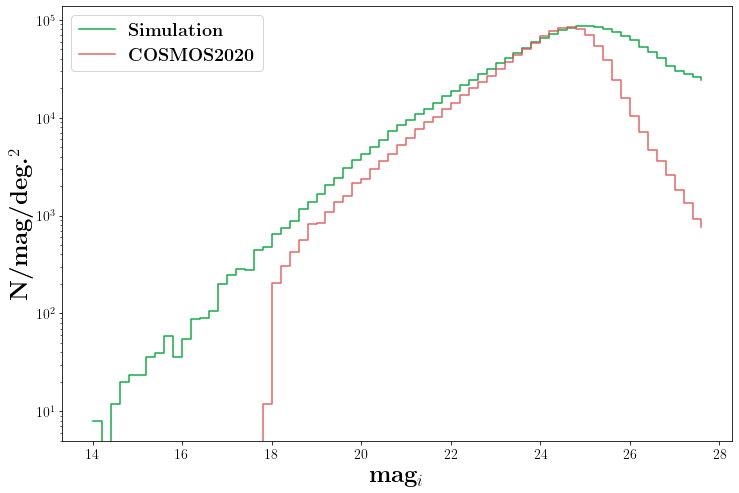

In [17]:
# Start with i-band number counts

# need to pre-compute so we can scale
h_sim = np.histogram(sim['m_hsc_sim'][:,2], bins=np.arange(14,28,0.2), density=False)[0]/1.27/0.2
#h_des = np.histogram(des['bdf_mag_dered_calib_i'], bins=np.arange(14,28,0.2), density=False)[0]*5/5.88/0.2
h_cos = np.histogram(cos['mag_i'], bins=np.arange(14,28,0.2), density=False)[0]/1.27/0.2

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_xlabel(r'\textbf{mag$_i$}', fontsize=24)
ax.set_ylabel(r'\textbf{N/mag/deg.$^2$}', fontsize=24)
ax.set_yscale('log')

ax.step(np.arange(14,28,0.2)[:-1], h_sim, where='post', c='#11aa46', label=r'\textbf{Simulation}')
#ax.step(np.arange(14,28,0.2)[:-1], h_des, where='post', c='#5555dd', label=r'\textbf{DES DF}')
ax.step(np.arange(14,28,0.2)[:-1], h_cos, where='post', c='#df5555', alpha=0.9, 
        label=r'\textbf{COSMOS2020}')

#ax.set_xlim([3300.,30000.])
#ax.set_ylim([-0.1*np.max(df_f[ob,:]/des_lam),1.5*np.max(df_f[ob,:]/des_lam)])
ax.legend(fontsize=18, loc=2)
plt.savefig("Number_counts.png")
plt.show()

In [18]:
def shift_cen(arr):    
    return arr[:-1] + (arr[1]-arr[0])/2.

def contour_plot(ax, xdata, ydata, limits, nbin, labels, colours):
    
    nlevel = 4
    #alpha = np.array([1,0.8,0.6,0.4,0.2]) # can't use alpha
    lw = [0.4, 0.8, 1.2, 1.6, 2]
    if type(colours[0]) is str:
        col = colours
    elif type(colours[0]) is int:
        col = np.array([BAND_COLORS['Y'], BAND_COLORS['g'], BAND_COLORS['r'], BAND_COLORS['u']])[colours]
    else:
        col = [BAND_COLORS['Y'], BAND_COLORS['g'], BAND_COLORS['r'], BAND_COLORS['u']]
    
    n_sets = len(xdata)
    if n_sets > 4:
        print("Error: can't plot more than four contour sets")
        return ax,[0,1]*2
        
    # find the axis limits, etc. (if not None, we assume they're fine)
    if limits is None:
        # find the 98%ile in each axis
        x_tmp = np.sort(np.hstack(xdata))
        y_tmp = np.sort(np.hstack(ydata))

        limits = [1.2*sorted(x_tmp)[int(0.01*len(x_tmp))]]
        limits.append(1.2*sorted(x_tmp)[int(0.99*len(x_tmp))])
        limits.append(1.2*sorted(y_tmp)[int(0.01*len(y_tmp))])
        limits.append(1.2*sorted(y_tmp)[int(0.99*len(y_tmp))])
            
    # 2d hist
    x_edges = limits[0] + (limits[1] - limits[0]) * np.arange(nbin+1) / nbin
    y_edges = limits[2] + (limits[3] - limits[2]) * np.arange(nbin+1) / nbin

    # plot each in turn
    for i in range(n_sets):
        z = np.histogram2d(xdata[i], ydata[i], bins=[x_edges, y_edges], normed=True)
        if i==0:
            zmax = np.max(z[0])*0.98

        # contour levels
        levels = 10.**((np.arange(nlevel+1) * (np.log10(zmax)+1) / nlevel) -1)

        X, Y = np.meshgrid(shift_cen(x_edges), shift_cen(y_edges))

        # plot
        ax.contour(X, Y, z[0].T, levels=levels, colors=col[i], linewidths=lw)
        
        ax_ranges = [ax.get_xlim()[1]-ax.get_xlim()[0], ax.get_ylim()[1]-ax.get_ylim()[0]]    
        ax.plot([ax.get_xlim()[1]+0.3*ax_ranges[0], ax.get_xlim()[1]+0.35*ax_ranges[0]], 
            [ax.get_ylim()[0]-0.3*ax_ranges[1], ax.get_ylim()[0]-0.3*ax_ranges[1]], label=labels[i], 
            color=col[i])

    ax.legend(fontsize=22, loc=2)
    return ax, limits

def panel_plot(xdata, ydata, nbin=41, limits=None, axlabels=None, labels=None, save=True, colours=None, 
               outname="tmp.png"):
                
    # set up figure
    fig = plt.figure(figsize=[8,8])
    ax = fig.add_subplot(111)
    if labels is not None:
        ax.set_xlabel(r'{}'.format(axlabels[0]), fontsize=22)
        ax.set_ylabel(r'{}'.format(axlabels[1]), fontsize=22)
    
    ax, lims = contour_plot(ax, xdata, ydata, limits, nbin, labels, colours=colours)
    print(lims)
    if np.all(np.array(lims[:2])<0.):
        ax.set_xlim([lims[1],lims[0]])
    else:
        ax.set_xlim(lims[:2])
    if np.all(np.array(lims[2:])<0.):
        ax.set_ylim([lims[3],lims[2]])
    else:
        ax.set_ylim(lims[2:])
    
    if save is True:
        fig.savefig(outname)
    plt.show()


In [19]:
# sim_sub = np.where((sim['m_des_sim'][:,2]<25))[0]
# des_sub = np.where((des['bdf_mag_dered_calib_i']<25))[0]

# panel_plot([(sim['m_des_sim'][:,0]-sim['m_des_sim'][:,1])[sim_sub], 
#             (des['bdf_mag_dered_calib_g']-des['bdf_mag_dered_calib_r'])[des_sub]],
#           [(sim['m_des_sim'][:,1]-sim['m_des_sim'][:,2])[sim_sub], 
#            (des['bdf_mag_dered_calib_r']-des['bdf_mag_dered_calib_i'])[des_sub]],
#           save=False, limits=[-0.5,2.,-0.5,1.7], axlabels=['$g-r$','$r-i$'], 
#            labels=['SkyPy','DES DF'], colours=[1,2])

In [20]:
# sim_sub = np.where((sim['m_des_sim'][:,2]<25))[0]
# des_sub = np.where((des['bdf_mag_dered_calib_i']<25))[0]

# panel_plot([(sim['m_des_true'][:,0]-sim['m_des_true'][:,1])[sim_sub], 
#             (des['bdf_mag_dered_calib_g']-des['bdf_mag_dered_calib_r'])[des_sub]],
#           [(sim['m_des_true'][:,1]-sim['m_des_true'][:,2])[sim_sub], 
#            (des['bdf_mag_dered_calib_r']-des['bdf_mag_dered_calib_i'])[des_sub]],
#           save=False, limits=[-0.5,2.,-0.5,1.7], axlabels=['$g-r$','$r-i$'], 
#            labels=['SkyPy','DES DF'], colours=[1,2])

/tmp/ipykernel_5242/2965327003.py:2: RuntimeWarning: invalid value encountered in log10
  cos_sub = np.where((23.9-2.5*np.log10(cos['HSC_i_FLUX'])<25))[0]
/tmp/ipykernel_5242/2965327003.py:4: RuntimeWarning: invalid value encountered in log10
  panel_plot([(-2.5*np.log10(cos['HSC_g_FLUX']/cos['HSC_r_FLUX']))[cos_sub],
/tmp/ipykernel_5242/2965327003.py:6: RuntimeWarning: invalid value encountered in log10
  [(-2.5*np.log10(cos['HSC_r_FLUX']/cos['HSC_i_FLUX']))[cos_sub],


[-0.5, 2.0, -0.5, 1.7]


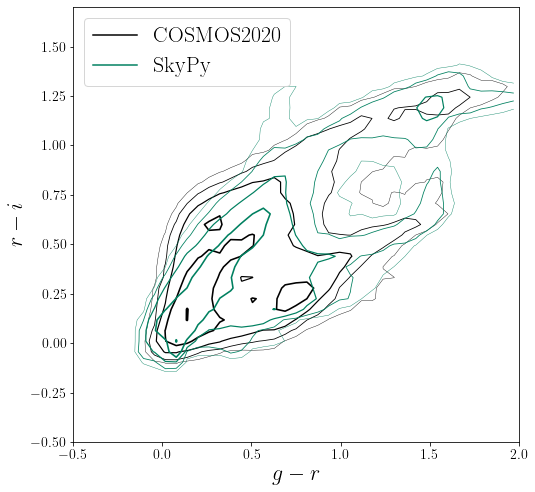

In [21]:
sim_sub = np.where((sim['m_hsc_sim'][:,2]<25))[0]
cos_sub = np.where((23.9-2.5*np.log10(cos['HSC_i_FLUX'])<25))[0]

panel_plot([(-2.5*np.log10(cos['HSC_g_FLUX']/cos['HSC_r_FLUX']))[cos_sub], 
            (sim['m_hsc_sim'][:,0]-sim['m_hsc_sim'][:,1])[sim_sub]],
          [(-2.5*np.log10(cos['HSC_r_FLUX']/cos['HSC_i_FLUX']))[cos_sub], 
           (sim['m_hsc_sim'][:,1]-sim['m_hsc_sim'][:,2])[sim_sub]],
          save=False, limits=[-0.5,2.,-0.5,1.7], axlabels=['$g-r$','$r-i$'], 
           labels=['COSMOS2020','SkyPy'], colours=[0,1])

[-0.5, 2.0, -0.5, 1.7]


/tmp/ipykernel_5242/2144384632.py:1: RuntimeWarning: invalid value encountered in log10
  panel_plot([(-2.5*np.log10(cos['HSC_g_FLUX']/cos['HSC_r_FLUX'])),
/tmp/ipykernel_5242/2144384632.py:3: RuntimeWarning: invalid value encountered in log10
  [(-2.5*np.log10(cos['HSC_r_FLUX']/cos['HSC_i_FLUX'])),


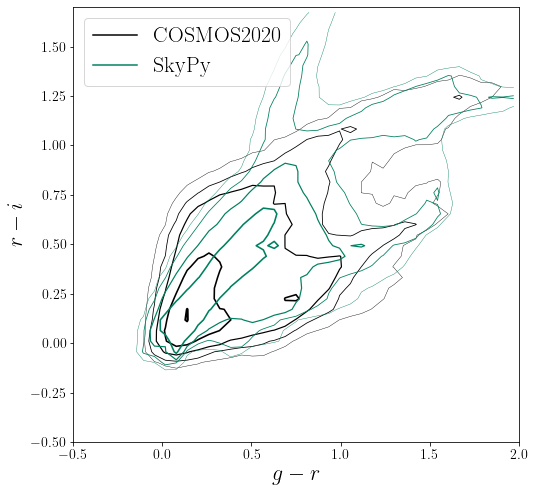

In [22]:
panel_plot([(-2.5*np.log10(cos['HSC_g_FLUX']/cos['HSC_r_FLUX'])), 
            (sim['m_hsc_true'][:,0]-sim['m_hsc_true'][:,1])],
          [(-2.5*np.log10(cos['HSC_r_FLUX']/cos['HSC_i_FLUX'])), 
           (sim['m_hsc_true'][:,1]-sim['m_hsc_true'][:,2])],
          save=False, limits=[-0.5,2.,-0.5,1.7], axlabels=['$g-r$','$r-i$'], 
           labels=['COSMOS2020','SkyPy'], colours=[0,1])

[0.0, 2.5, -23.5, -15]


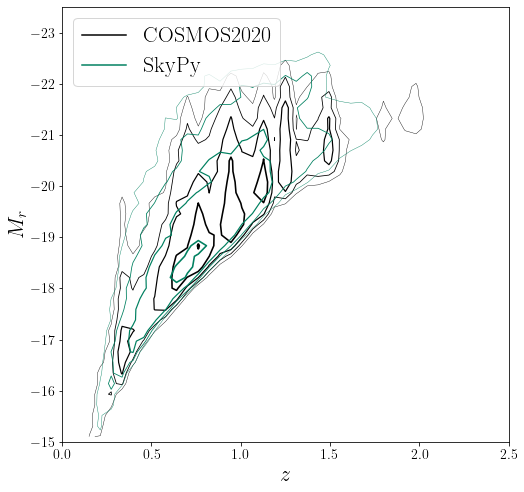

In [23]:
panel_plot([cos['photoz'][cos_sub], 
            sim['z'][sim_sub]],
          [cos['lp_MR'][cos_sub], 
           sim['M_r'][sim_sub]],
          save=False, limits=[0.,2.5,-23.5,-15], axlabels=['$z$','$M_r$'], 
           labels=['COSMOS2020','SkyPy'], colours=[0,1])

[0.0, 2.5, 7.5, 12]


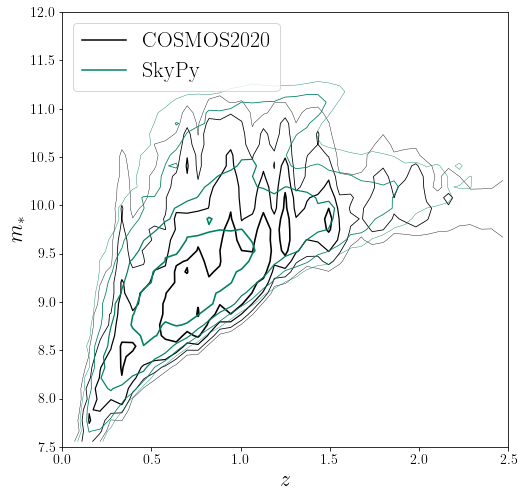

In [24]:
panel_plot([cos['photoz'][cos_sub], 
            sim['z'][sim_sub]],
          [cos['kcorr_mass'][cos_sub], 
           np.log10(sim['sm_remain'][sim_sub])],
          save=True, limits=[0.,2.5,7.5,12], axlabels=['$z$','$m_*$'], 
           labels=['COSMOS2020','SkyPy'], colours=[0,1], outname="mass_redshift.png")

[-23.5, -15, 7.5, 12]


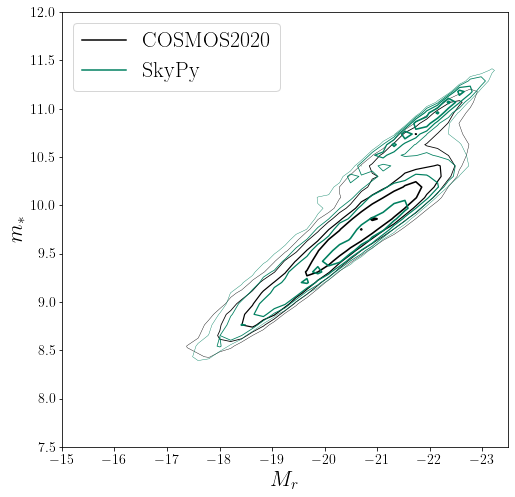

In [25]:
panel_plot([cos['lp_MR'][cos_sub], 
            sim['M_r'][sim_sub]],
          [cos['kcorr_mass'][cos_sub], 
           np.log10(sim['sm_remain'][sim_sub])],
          save=False, limits=[-23.5,-15,7.5,12], axlabels=['$M_r$','$m_*$'], 
           labels=['COSMOS2020','SkyPy'], colours=[0,1])

In [26]:
# need to add the weights?
norms = np.array([7.8800161e-12, 5.0557465e-09, 8.0048974e-11, 1.0215842e-11, 1.3721980e-10])
#weights = np.array([7.31798350e-01, 7.74462862e-04, 1.90468822e-01, 2.09681844e+00, 1.11666356e-01])
weights = np.array([1.26903294e+11, 1.97794727e+08, 1.24923525e+10, 9.78871835e+10, 7.28757803e+09])
coeff_norm = coeffs * weights 
#coeff_norm = coeffs / norms
for i in range(coeff_norm.shape[0]):
    coeff_norm[i,:] = coeff_norm[i,:] / np.sum(coeff_norm[i,:])
    
# clean nans
coeff_norm[np.isinf(coeff_norm)] = 0
coeff_norm[np.isnan(coeff_norm)] = 0

/tmp/ipykernel_5242/3789403096.py:8: RuntimeWarning: invalid value encountered in true_divide
  coeff_norm[i,:] = coeff_norm[i,:] / np.sum(coeff_norm[i,:])


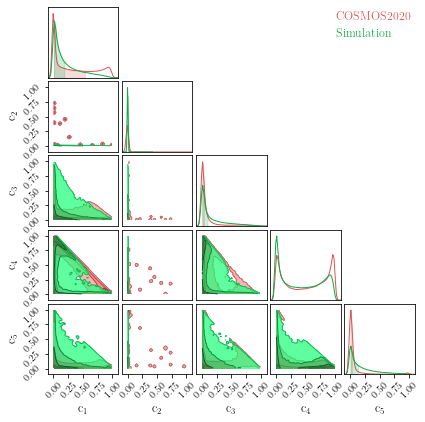

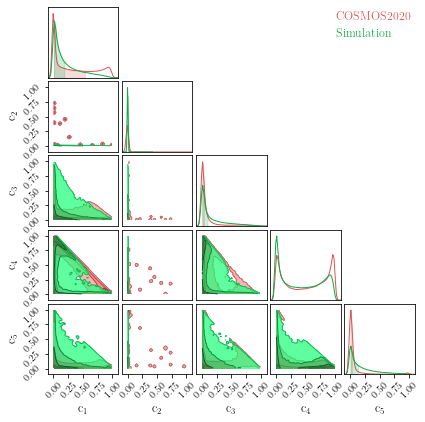

In [27]:
c = ChainConsumer()

c.add_chain(coeff_norm[cos_sub,:], 
             parameters=['c$_1$','c$_2$','c$_3$','c$_4$','c$_5$'], 
            name=r'COSMOS2020', color='#df5555')

c.add_chain(sim['coeff'][sim['m_hsc_sim'][:,2]<25.,:], 
            parameters=['c$_1$','c$_2$','c$_3$','c$_4$','c$_5$'], 
            name=r'Simulation', color='#11aa46')

c.configure(sigmas=[0,0.5,1,2], smooth=1, shade=True)

c.plotter.plot(filename="coeffs.png", 
                extents=[(-0.1,1.1),(-0.1,1.1),(-0.1,1.1),(-0.1,1.1),(-0.1,1.1)], 
               figsize=(6,6))#, truth=mean)

### curious that component2 is never used - check that the coeffs don't need scaling.
### Well, I guess the M/L info is not in here.

In [28]:
cos_sf = np.where((23.9-2.5*np.log10(cos['HSC_i_FLUX'])<25)&(cos['UVJ_type']==False))[0]
cos_p = np.where((23.9-2.5*np.log10(cos['HSC_i_FLUX'])<25)&(cos['UVJ_type']==True))[0]

/tmp/ipykernel_5242/1937348485.py:1: RuntimeWarning: invalid value encountered in log10
  cos_sf = np.where((23.9-2.5*np.log10(cos['HSC_i_FLUX'])<25)&(cos['UVJ_type']==False))[0]
/tmp/ipykernel_5242/1937348485.py:2: RuntimeWarning: invalid value encountered in log10
  cos_p = np.where((23.9-2.5*np.log10(cos['HSC_i_FLUX'])<25)&(cos['UVJ_type']==True))[0]


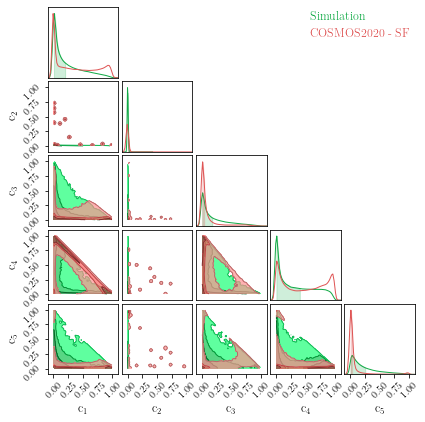

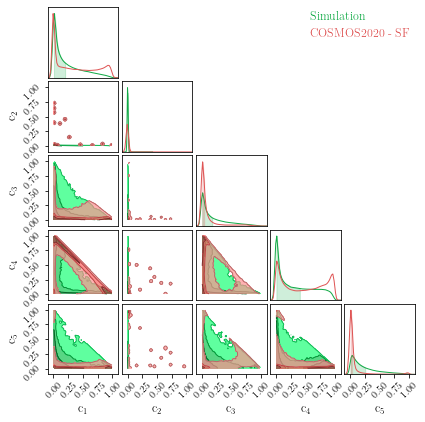

In [29]:
cs = ChainConsumer()
cs.add_chain(sim_sf['coeff'][sim_sf['m_hsc_sim'][:,2]<25.,:], 
            parameters=['c$_1$','c$_2$','c$_3$','c$_4$','c$_5$'], 
            name=r'Simulation', color='#11aa46')

cs.add_chain(coeff_norm[cos_sf,:], 
             parameters=['c$_1$','c$_2$','c$_3$','c$_4$','c$_5$'], 
            name=r'COSMOS2020 - SF', color='#df5555')

cs.configure(sigmas=[0,0.5,1,2], smooth=1, shade=True)

cs.plotter.plot(filename="coeffs_sf.png", 
                extents=[(-0.1,1.1),(-0.1,1.1),(-0.1,1.1),(-0.1,1.1),(-0.1,1.1)], 
               figsize=(6,6))#, truth=mean)

(297948, 5)


/tmp/ipykernel_5242/1119058887.py:7: RuntimeWarning: invalid value encountered in true_divide
  coeffs[i,:] = coeffs[i,:] / np.sum(coeffs[i,:])


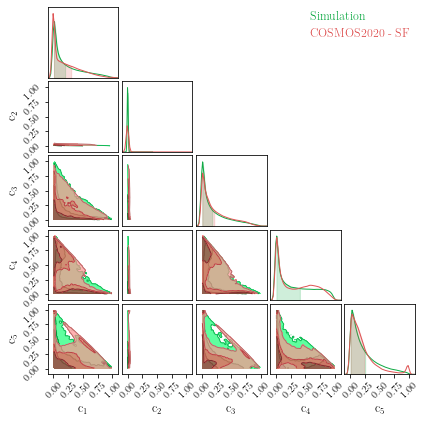

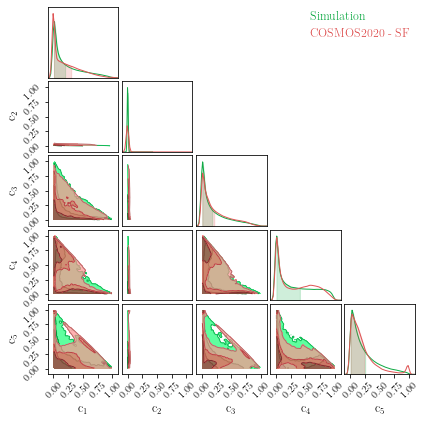

In [30]:
sim_sf_norm = sim_sf['coeff'] / weights
print(sim_sf_norm.shape)
for i in range(sim_sf_norm.shape[0]):
    sim_sf_norm[i,:] = sim_sf_norm[i,:] / np.sum(sim_sf_norm[i,:])

for i in range(coeffs.shape[0]):
    coeffs[i,:] = coeffs[i,:] / np.sum(coeffs[i,:])
    
# clean nans
coeffs[np.isinf(coeffs)] = 0
coeffs[np.isnan(coeffs)] = 0

cs = ChainConsumer()
cs.add_chain(sim_sf['coeff'][sim_sf['m_hsc_sim'][:,2]<25.,:], 
            parameters=['c$_1$','c$_2$','c$_3$','c$_4$','c$_5$'], 
            name=r'Simulation', color='#11aa46')

cs.add_chain(coeffs[cos_sf,:], 
             parameters=['c$_1$','c$_2$','c$_3$','c$_4$','c$_5$'], 
            name=r'COSMOS2020 - SF', color='#df5555')

cs.configure(sigmas=[0,0.5,1,2], smooth=1, shade=True)

cs.plotter.plot(filename="coeffs_sf_alt.png", 
                extents=[(-0.1,1.1),(-0.1,1.1),(-0.1,1.1),(-0.1,1.1),(-0.1,1.1)], 
               figsize=(6,6))#, truth=mean)

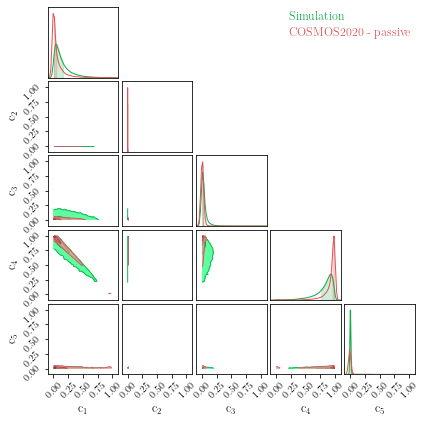

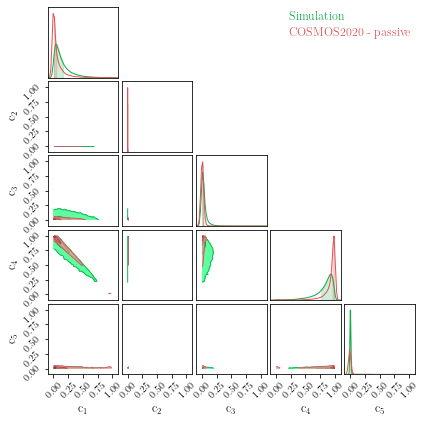

In [31]:
cp = ChainConsumer()

cp.add_chain(sim_p['coeff'][sim_p['m_hsc_sim'][:,2]<25.,:], 
            parameters=['c$_1$','c$_2$','c$_3$','c$_4$','c$_5$'], 
            name=r'Simulation', color='#11aa46')

cp.add_chain(coeff_norm[cos_p,:], 
             parameters=['c$_1$','c$_2$','c$_3$','c$_4$','c$_5$'], 
            name=r'COSMOS2020 - passive', color='#df5555')

cp.configure(sigmas=[0,0.5,1,2], smooth=1, shade=True)

cp.plotter.plot(filename="coeffs_p.png", 
                extents=[(-0.1,1.1),(-0.1,1.1),(-0.1,1.1),(-0.1,1.1),(-0.1,1.1)], 
               figsize=(6,6))#, truth=mean)

/tmp/ipykernel_5242/824433767.py:3: RuntimeWarning: invalid value encountered in log10
  panel_plot([(-2.5*np.log10(cos['HSC_g_FLUX']/cos['HSC_r_FLUX']))[cos_sf],
/tmp/ipykernel_5242/824433767.py:5: RuntimeWarning: invalid value encountered in log10
  [(-2.5*np.log10(cos['HSC_r_FLUX']/cos['HSC_i_FLUX']))[cos_sf],


[-0.5, 2.0, -0.5, 1.7]


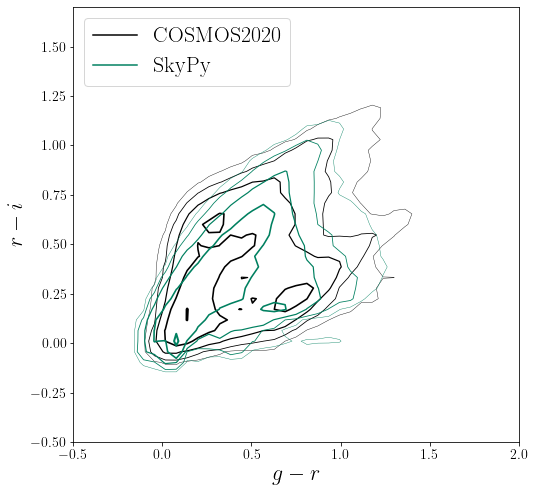

In [32]:
sim_sub = np.where((sim_sf['m_hsc_sim'][:,2]<25))[0]           

panel_plot([(-2.5*np.log10(cos['HSC_g_FLUX']/cos['HSC_r_FLUX']))[cos_sf],
           (sim_sf['m_hsc_sim'][:,0]-sim_sf['m_hsc_sim'][:,1])[sim_sub]],
          [(-2.5*np.log10(cos['HSC_r_FLUX']/cos['HSC_i_FLUX']))[cos_sf],
          (sim_sf['m_hsc_sim'][:,1]-sim_sf['m_hsc_sim'][:,2])[sim_sub]],
          save=False, limits=[-0.5,2.,-0.5,1.7], axlabels=['$g-r$','$r-i$'], 
           labels=['COSMOS2020','SkyPy'], colours=[0,1])

[0.0, 2.5, 7.5, 12]


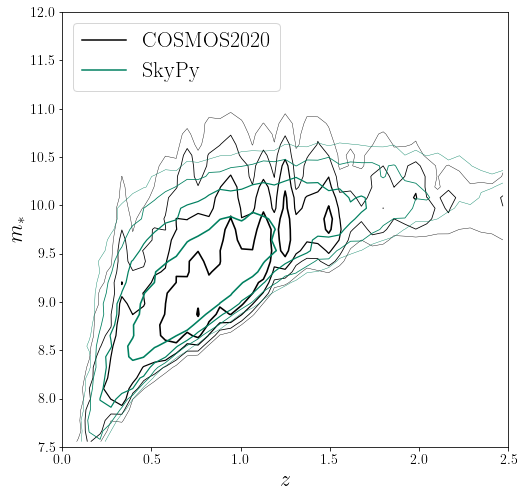

In [33]:
panel_plot([cos['photoz'][cos_sf], 
            sim_sf['z'][sim_sub]],
          [cos['kcorr_mass'][cos_sf], 
           np.log10(sim_sf['sm_remain'][sim_sub])],
          save=False, limits=[0.,2.5,7.5,12], axlabels=['$z$','$m_*$'], 
           labels=['COSMOS2020','SkyPy'], colours=[0,1])

[-0.5, 2.2, -0.5, 1.7]


/tmp/ipykernel_5242/2940049482.py:3: RuntimeWarning: invalid value encountered in log10
  panel_plot([(-2.5*np.log10(cos['HSC_g_FLUX']/cos['HSC_r_FLUX']))[cos_p],
/tmp/ipykernel_5242/2940049482.py:5: RuntimeWarning: invalid value encountered in log10
  [(-2.5*np.log10(cos['HSC_r_FLUX']/cos['HSC_i_FLUX']))[cos_p],


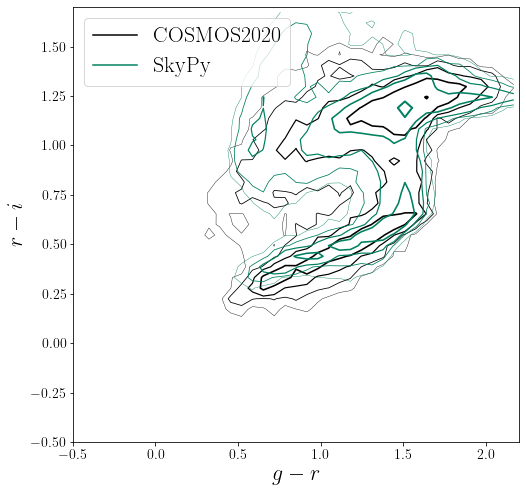

In [34]:
sim_sub = np.where((sim_p['m_hsc_sim'][:,2]<25))[0]

panel_plot([(-2.5*np.log10(cos['HSC_g_FLUX']/cos['HSC_r_FLUX']))[cos_p],
           (sim_p['m_hsc_sim'][:,0]-sim_p['m_hsc_sim'][:,1])[sim_sub]],
          [(-2.5*np.log10(cos['HSC_r_FLUX']/cos['HSC_i_FLUX']))[cos_p],
          (sim_p['m_hsc_sim'][:,1]-sim_p['m_hsc_sim'][:,2])[sim_sub]],
          save=True, limits=[-0.5,2.2,-0.5,1.7], axlabels=['$g-r$','$r-i$'], 
           labels=['COSMOS2020','SkyPy'], colours=[0,1], outname="passive_col_col.png")

[0.0, 2.5, 7.5, 12.5]


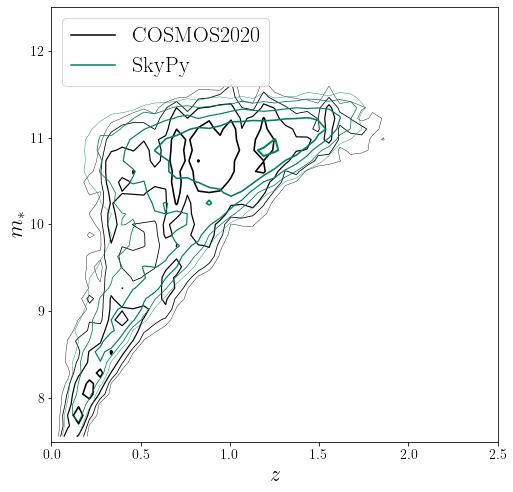

In [35]:
panel_plot([cos['photoz'][cos_p], 
            sim_p['z'][sim_sub]],
          [cos['kcorr_mass'][cos_p], 
           np.log10(sim_p['sm_remain'][sim_sub])],
          save=False, limits=[0.,2.5,7.5,12.5], axlabels=['$z$','$m_*$'], 
           labels=['COSMOS2020','SkyPy'], colours=[0,1])

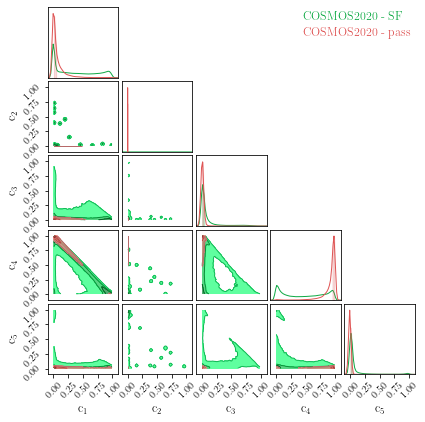

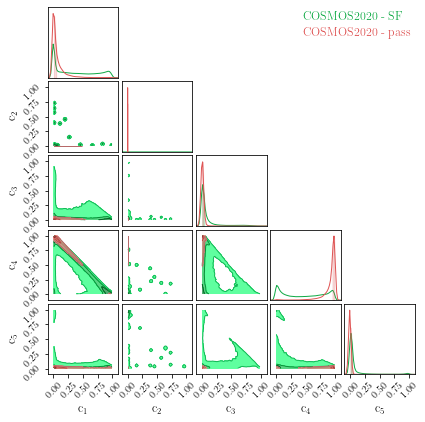

In [36]:
csp = ChainConsumer()
csp.add_chain(coeff_norm[cos_sf,:], 
             parameters=['c$_1$','c$_2$','c$_3$','c$_4$','c$_5$'], 
            name=r'COSMOS2020 - SF', color='#11aa46')
csp.add_chain(coeff_norm[cos_p,:], 
             parameters=['c$_1$','c$_2$','c$_3$','c$_4$','c$_5$'], 
            name=r'COSMOS2020 - pass', color='#df5555')

# cs.add_chain(sim['coeff'][sim_sf][sim['m_hsc_sim'][sim_sf,2]<25.,:], 
#             parameters=['c$_1$','c$_2$','c$_3$','c$_4$','c$_5$'], 
#             name=r'Simulation', color='#11aa46')

csp.configure(sigmas=[0,0.5,1,2], smooth=1, shade=True)

csp.plotter.plot(filename="coeffs_sf_pass.png", 
                extents=[(-0.1,1.1),(-0.1,1.1),(-0.1,1.1),(-0.1,1.1),(-0.1,1.1)], 
               figsize=(6,6))#, truth=mean)

In [37]:
# looking into coeffs
coff_p = coeffs[cos_p,:] * norms
z_p = cos['photoz'][cos_p]

In [38]:
print(np.mean(coff_p[(z_p>0.1)&(z_p<0.4),:], axis=0))
print(np.var(coff_p[(z_p>0.1)&(z_p<0.4),:], axis=0))

[2.08939090e-13 1.92848363e-14 5.40666186e-12 9.16705516e-12
 1.18036336e-12]
[3.10347983e-25 6.88129458e-27 5.60482207e-23 1.97225861e-24
 8.37205963e-24]


In [39]:
print(np.mean(coff_p[(z_p>1.5),:], axis=0))
print(np.var(coff_p[(z_p>1.5),:], axis=0))

[5.62027993e-13 7.85025776e-14 7.33844214e-12 8.45505522e-12
 1.28236321e-12]
[6.64965330e-25 3.80866068e-26 4.63935406e-23 2.34287723e-24
 3.01196557e-24]


In [40]:
coff_s = coeffs[cos_sf,:] * norms
z_s = cos['photoz'][cos_sf]

In [41]:
print(np.mean(coff_s[(z_s>0.1)&(z_s<0.4),:], axis=0))
print(np.var(coff_s[(z_s>0.1)&(z_s<0.4),:], axis=0))
print(np.mean(coff_s[(z_s>1.5),:], axis=0))
print(np.var(coff_s[(z_s>1.5),:], axis=0))

[1.09070867e-12 3.29054536e-12 1.82689555e-11 5.00872111e-12
 1.95432269e-11]
[2.24326215e-24 5.06990212e-23 2.57990698e-22 1.05467364e-23
 5.82688540e-22]
[2.37575057e-12 1.65975305e-11 7.39201288e-12 2.07885475e-12
 5.47316716e-11]
[4.30840449e-24 7.59142683e-21 1.30308401e-22 5.88905371e-24
 1.53633514e-21]


In [42]:
alpha = np.array([0.40607936, 0.03563725, 1.15169039, 12.06335464, 0.17928599])

In [43]:
atmp = alpha / 10000.
alph0 = np.sum(atmp)
va = atmp*(alph0 - atmp) / (alph0**2 * (alph0 + 1))
va

array([0.02844863, 0.0025655 , 0.07620433, 0.11155192, 0.01277231])

In [44]:
sim_sub_p = np.where((sim_p['m_hsc_sim'][:,2]<25)&(sim_p['z']>0.65)&(sim_p['z']<0.7))[0]
sim_sub_sf = np.where((sim_sf['m_hsc_sim'][:,2]<25)&(sim_sf['z']>0.65)&(sim_sf['z']<0.7))[0]
sim_tot = np.concatenate([sim_p[sim_sub_p], sim_sf[sim_sub_sf]])

In [45]:
sim_tot['m_hsc_sim']

array([[26.48854923, 24.89652532, 23.65460684, 23.23967791, 22.98788437],
       [22.88321801, 21.54592417, 20.55758859, 20.23048352, 19.99704393],
       [23.74476908, 22.14398674, 20.90580651, 20.46978584, 20.21427729],
       ...,
       [24.70134032, 24.08560067, 23.48568311, 23.31424495, 23.20490469],
       [21.69109172, 21.34338249, 20.99771252, 20.95174254, 20.8782574 ],
       [22.47244539, 21.66074719, 21.03426581, 20.93132144, 20.83900489]])

In [46]:
cos_sub = np.where((23.9-2.5*np.log10(cos['HSC_i_FLUX'])<25)&(cos['photoz']<0.7)&(cos['photoz']>0.65))[0]

/tmp/ipykernel_5242/2268106688.py:1: RuntimeWarning: invalid value encountered in log10
  cos_sub = np.where((23.9-2.5*np.log10(cos['HSC_i_FLUX'])<25)&(cos['photoz']<0.7)&(cos['photoz']>0.65))[0]


/tmp/ipykernel_5242/3188525482.py:2: RuntimeWarning: invalid value encountered in log10
  [(-2.5*np.log10(cos['HSC_r_FLUX']/cos['HSC_i_FLUX']))[cos_sub],


[7.0, 12.5, -0.5, 2.0]


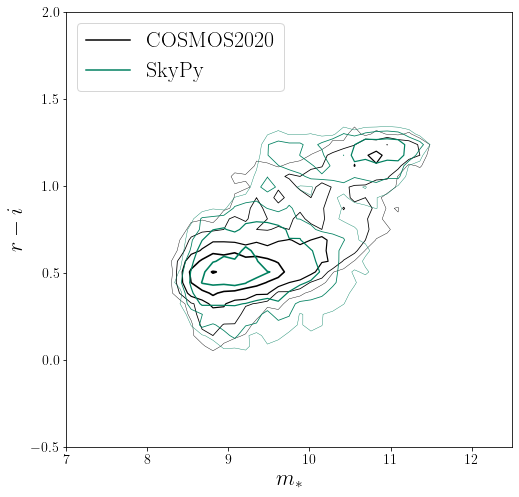

In [47]:
panel_plot([cos['kcorr_mass'][cos_sub], np.log10(sim_tot['sm_remain'])],
          [(-2.5*np.log10(cos['HSC_r_FLUX']/cos['HSC_i_FLUX']))[cos_sub],
          (sim_tot['m_hsc_sim'][:,1]-sim_tot['m_hsc_sim'][:,2])],
          limits=[7.,12.5,-0.5,2.], axlabels=['$m_*$','$r-i$'], 
           labels=['COSMOS2020','SkyPy'], colours=[0,1], outname="colour_mass.png")